# Описание проекта

Задача - создать прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В наличии данные с параметрами добычи и очистки. 

Модель позволит оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

Данные находятся в трёх файлах:

* 		gold_recovery_train.csv — обучающая выборка
* 		gold_recovery_test.csv — тестовая выборка
* 		gold_recovery_full.csv — исходные данные

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.

В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте их на корректность.

## Инструкция по выполнению проекта

### 1. Подготовьте данные

1.1. Откройте файлы и изучите их.

Путь к файлам:
* 		/datasets/gold_recovery_train.csv.
* 		/datasets/gold_recovery_test.csv.
* 		/datasets/gold_recovery_full.csv.

1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

1.4. Проведите предобработку данных.

#### 2. Проанализируйте данные

2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

#### 3. Постройте модель

3.1. Напишите функцию для вычисления итоговой sMAPE.

3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

# 1. Подготовка данных

### 1.1. Откройте файлы и изучите их

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from matplotlib.pyplot import show
from scipy.stats import norm
from scipy import stats

# Читаем исходные файлы
data = pd.read_csv('/datasets/gold_recovery_full.csv', index_col = 'date', parse_dates = ['date'])
data_train = pd.read_csv('/datasets/gold_recovery_train.csv', index_col = 'date', parse_dates = ['date'])
data_test = pd.read_csv('/datasets/gold_recovery_test.csv', index_col = 'date', parse_dates = ['date'])

# Смотрим общую информацию по каждому файлу + пропуски + дубликаты
def info_func(frame_name):
    print('---INFO---')
    display(frame_name.info())
    print('---SIZE---')
    display(frame_name.shape)
    print('---HEAD 10---')
    display(frame_name.head(10))
    print('---DESCRIBE---')
    display(frame_name.describe())
    print('---SPACES---')
    display(frame_name.isnull().sum())
    print('---DUPLICATES---')
    display(frame_name.duplicated().sum())

#### Файл `gold_recovery_full`

In [2]:
info_func(data)

---INFO---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22716 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant                      21170 non-null float6

None

---SIZE---


(22716, 86)

---HEAD 10---


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


---DESCRIBE---


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22627.000000,22629.000000,22331.000000,22630.000000,20753.000000,22633.000000,22516.000000,22445.000000,22635.000000,21107.000000,...,22571.000000,22587.000000,22608.000000,22607.000000,22615.000000,22615.000000,22615.000000,22616.000000,22597.000000,22615.000000
mean,4.781559,9.095308,8.640317,40.001172,67.447488,8.923690,2.488252,9.523632,2.827459,140.277672,...,18.205125,-499.878977,14.356474,-476.532613,14.883276,-503.323288,11.626743,-500.521502,17.976810,-519.361465
std,2.030128,3.230797,3.785035,13.398062,11.616034,3.517917,1.189407,4.079739,1.262834,49.919004,...,6.560700,80.273964,5.655791,93.822791,6.372811,72.925589,5.757449,78.956292,6.636203,75.477151
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.018525,8.750171,7.116799,42.383721,63.282393,7.684016,1.805376,8.143576,2.303108,110.177081,...,14.095940,-500.896232,10.882675,-500.309169,10.941299,-500.628697,8.037533,-500.167897,13.968418,-500.981671
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.862593,10.929839,10.705824,46.111999,72.950836,11.084557,3.287790,11.860824,3.555077,174.049914,...,22.998194,-498.361545,17.977502,-400.224147,18.014914,-498.489381,14.001193,-499.492354,23.009704,-499.526388
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


---SPACES---


final.output.concentrate_ag                     89
final.output.concentrate_pb                     87
final.output.concentrate_sol                   385
final.output.concentrate_au                     86
final.output.recovery                         1963
                                              ... 
secondary_cleaner.state.floatbank5_a_level     101
secondary_cleaner.state.floatbank5_b_air       101
secondary_cleaner.state.floatbank5_b_level     100
secondary_cleaner.state.floatbank6_a_air       119
secondary_cleaner.state.floatbank6_a_level     101
Length: 86, dtype: int64

---DUPLICATES---


22

#### Файл `gold_recovery_train`

In [3]:
info_func(data_train)

---INFO---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float6

None

---SIZE---


(16860, 86)

---HEAD 10---


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,123.819808,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,122.270188,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,117.988169,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,115.581252,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,117.322323,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,124.592960,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,131.781026,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188


---DESCRIBE---


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16788.000000,16788.000000,16490.000000,16789.000000,15339.000000,16794.000000,16677.000000,16715.000000,16794.000000,15553.000000,...,16731.000000,16747.000000,16768.000000,16767.000000,16775.000000,16775.000000,16775.000000,16776.000000,16757.000000,16775.000000
mean,4.716907,9.113559,8.301123,39.467217,67.213166,8.757048,2.360327,9.303932,2.687512,129.479789,...,19.101874,-494.164481,14.778164,-476.600082,15.779488,-500.230146,12.377241,-498.956257,18.429208,-521.801826
std,2.096718,3.389495,3.825760,13.917227,11.960446,3.634103,1.215576,4.263208,1.272757,45.386931,...,6.883163,84.803334,5.999149,89.381172,6.834703,76.983542,6.219989,82.146207,6.958294,77.170888
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.971262,8.825748,6.939185,42.055722,62.625685,7.610544,1.641604,7.870275,2.172953,103.064021,...,14.508299,-500.837689,10.741388,-500.269182,10.977713,-500.530594,8.925586,-500.147603,13.977626,-501.080595
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.821176,11.054809,10.289741,45.976222,72.824595,10.971110,3.192404,11.648573,3.416936,159.539839,...,24.983961,-494.648754,20.023751,-400.137948,20.000701,-496.531781,15.979467,-498.418000,24.984992,-499.565540
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


---SPACES---


final.output.concentrate_ag                     72
final.output.concentrate_pb                     72
final.output.concentrate_sol                   370
final.output.concentrate_au                     71
final.output.recovery                         1521
                                              ... 
secondary_cleaner.state.floatbank5_a_level      85
secondary_cleaner.state.floatbank5_b_air        85
secondary_cleaner.state.floatbank5_b_level      84
secondary_cleaner.state.floatbank6_a_air       103
secondary_cleaner.state.floatbank6_a_level      85
Length: 86, dtype: int64

---DUPLICATES---


16

#### Файл `gold_recovery_test`

In [4]:
info_func(data_test)

---INFO---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5856 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
primary_cleaner.input.sulfate                 5554 non-null float64
primary_cleaner.input.depressant              5572 non-null float64
primary_cleaner.input.feed_size               5856 non-null float64
primary_cleaner.input.xanthate                5690 non-null float64
primary_cleaner.state.floatbank8_a_air        5840 non-null float64
primary_cleaner.state.floatbank8_a_level      5840 non-null float64
primary_cleaner.state.floatbank8_b_air        5840 non-null float64
primary_cleaner.state.floatbank8_b_level      5840 non-null float64
primary_cleaner.state.floatbank8_c_air        5840 non-null float64
primary_cleaner.state.floatbank8_c_level      5840 non-null float64
primary_cleaner.state.floatbank8_d_air        5840 non-null float64
primary_cleaner.state.floatbank8_d_level      5840 non-null float64
rougher.input.feed_ag         

None

---SIZE---


(5856, 52)

---HEAD 10---


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,-497.903666,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,-497.923683,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,-503.451306,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,-499.890350,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716


---DESCRIBE---


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5554.000000,5572.000000,5856.000000,5690.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,...,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,170.515243,8.482873,7.264651,1.321420,1481.990241,-509.057796,1486.908670,-511.743956,1468.495216,-509.741212,...,15.636031,-516.266074,13.145702,-476.338907,12.308967,-512.208126,9.470986,-505.017827,16.678722,-512.351694
std,49.608602,3.353105,0.611526,0.693246,310.453166,61.339256,313.224286,67.139074,309.980748,62.671873,...,4.660835,62.756748,4.304086,105.549424,3.762827,58.864651,3.312471,68.785898,5.404514,69.919839
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,143.340022,6.411500,6.885625,0.888769,1497.190681,-500.455211,1497.150234,-500.936639,1437.050321,-501.300441,...,12.057838,-501.054741,11.880119,-500.419113,10.123459,-500.879383,7.991208,-500.223089,13.012422,-500.833821
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,207.240761,10.017725,7.650000,1.763797,1601.681656,-499.575313,1601.784707,-499.323361,1600.785573,-499.009545,...,18.030985,-499.441529,15.940011,-401.523664,15.017881,-499.297033,11.992176,-499.722835,21.009076,-499.395621
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


---SPACES---


primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257
rougher.input.floatbank10_xanthate            123


---DUPLICATES---


6

### 1.1. Выводы.

- исходные датафреймы представлены:
    - `gold_recovery_full`: 22 716 записями и 86 признаками
    - `gold_recovery_train`: 16 860 записями и 86 признаками
    - `gold_recovery_test`: 5 856 записями и 52 признаками (помним о том, что некоторые признаки недоступны, т.к. замеряются и/или рассчитываются значительно позже)
- тип данных признаков во всех датафреймах (float64) подходит для дальнейших, необходимых в ходе проекта, вычислений
- обнаружены пробелы и дубликаты, с которыми разберемся позднее

### 1.2. Проверьте, что эффективность обогащения рассчитана правильно. Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака.

In [5]:
# Создаем функцию для расчета эффективности обогащения
def enrichment_effectivity(col):
    C = col['rougher.output.concentrate_au']
    F = col['rougher.input.feed_au']
    T = col['rougher.output.tail_au']
    try:  
        recovery = (C*(F-T))/(F*(C-T))*100
        return recovery
    except:
        return print("Деление на '0'")
    
# Вычисляем среднее значение абсолютных отклонений (MAE) для обучающией выборки   
data_train_wo_nan = data_train.dropna()
data_train_wo_nan['ror_check'] = enrichment_effectivity(data_train_wo_nan)
print("MAE = ", mean_absolute_error(
    data_train_wo_nan['ror_check'],
    data_train_wo_nan['rougher.output.recovery']))

display(data_train_wo_nan[['ror_check', 'rougher.output.recovery']].describe())

MAE =  9.555596961987514e-15


,ror_check,rougher.output.recovery
count,11017.000000,11017.000000
mean,82.741888,82.741888
std,13.590523,13.590523
min,-0.000000,0.000000
25%,79.997468,79.997468
50%,84.847754,84.847754
75%,89.635149,89.635149
max,100.000000,100.000000


### 1.2. Выводы.

- значение `MAE` = `9.555596961987514e-15` говорит о корректности расчета эффективности обогащения для признака `rougher.output.recovery`

### 1.3. Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [6]:
#Определяем отсутствующие в тестовой выборке признаки (кроме двух целевых признаков)
abcent_columns = list(set(data.columns) - set(data_test.columns) - set(['final.output.recovery','rougher.output.recovery']))
print(abcent_columns)

['rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.output.tail_ag', 'primary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_ag', 'final.output.tail_pb', 'rougher.calculation.floatbank10_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 'final.output.tail_sol', 'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.tail_au', 'primary_cleaner.output.concentrate_ag', 'rougher.output.tail_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb', 'final.output.tail_ag', 'secondary_cleaner.output.tail_pb', 'rougher.calculation.sulfate_to_au_concentrate', 'rougher.output.tail_sol', 'primary_cleaner.output.tail_sol', 'secondary_cleaner.output.tail_au', 'rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_au', 'secondary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'final.output.concentrate_ag', 'final.output.concentrate_sol', 'final.output.concentrate_au', 

### 1.3. Выводы.

В связи с тем, что по условиям проекта, некоторые параметры недоступны, так как замеряются и/или рассчитываются позднее - в тестовой выборке отсутствуют признаки, которые есть в обучающей. Они относятся к типам `output` (параметры продукта) и `state` (расчётные характеристики). Также в тестовом наборе нет целевых признаков `rougher.output.recovery` и `final.output.recovery`.

### 1.4. Проведите предобработку данных.

#### Пропуски

Так как близкие, по времени создания (date), атрибуты имеют близкие значения внутри одного признака - применим метод `interpolate` для заполнения пропусков

In [7]:
data = data.interpolate(method = 'time')
data_train = data_train.interpolate(method = 'time')
data_test = data_test.interpolate(method = 'time')

Проверим

In [8]:
print(data.isnull().sum())

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64


In [9]:
print(data_train.isnull().sum())

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64


In [10]:
print(data_test.isnull().sum())

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

#### Дубликаты

In [11]:
print("Количество дубликатов в 'data':", data.duplicated().sum())
print("Количество дубликатов в 'data_train':",data_train.duplicated().sum())
print("Количество дубликатов в 'data_test':",data_test.duplicated().sum())

Количество дубликатов в 'data': 0
Количество дубликатов в 'data_train': 0
Количество дубликатов в 'data_test': 0


# 1. Выводы.

- в исходных датафреймах наблюдались пропуски и дубликаты. Пропуски были устранены применением метода `interpolate` c параметром `time`, так как, по условиям проекта, близкие по времени парамеиры чаще всего схожи. Этим также удалось избавиться от дубликатов.
- рассчитанное, для обучающей выборки, значение `MAE` = `9.555596961987514e-15` говорит о корректности расчета эффективности обогащения для признака `rougher.output.recovery`
- некоторые параметры недоступны, так как замеряются и/или рассчитываются позднее - в тестовой выборке отсутствуют признаки, которые есть в обучающей

# 2. Анализ данных

### 2.1. Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы.

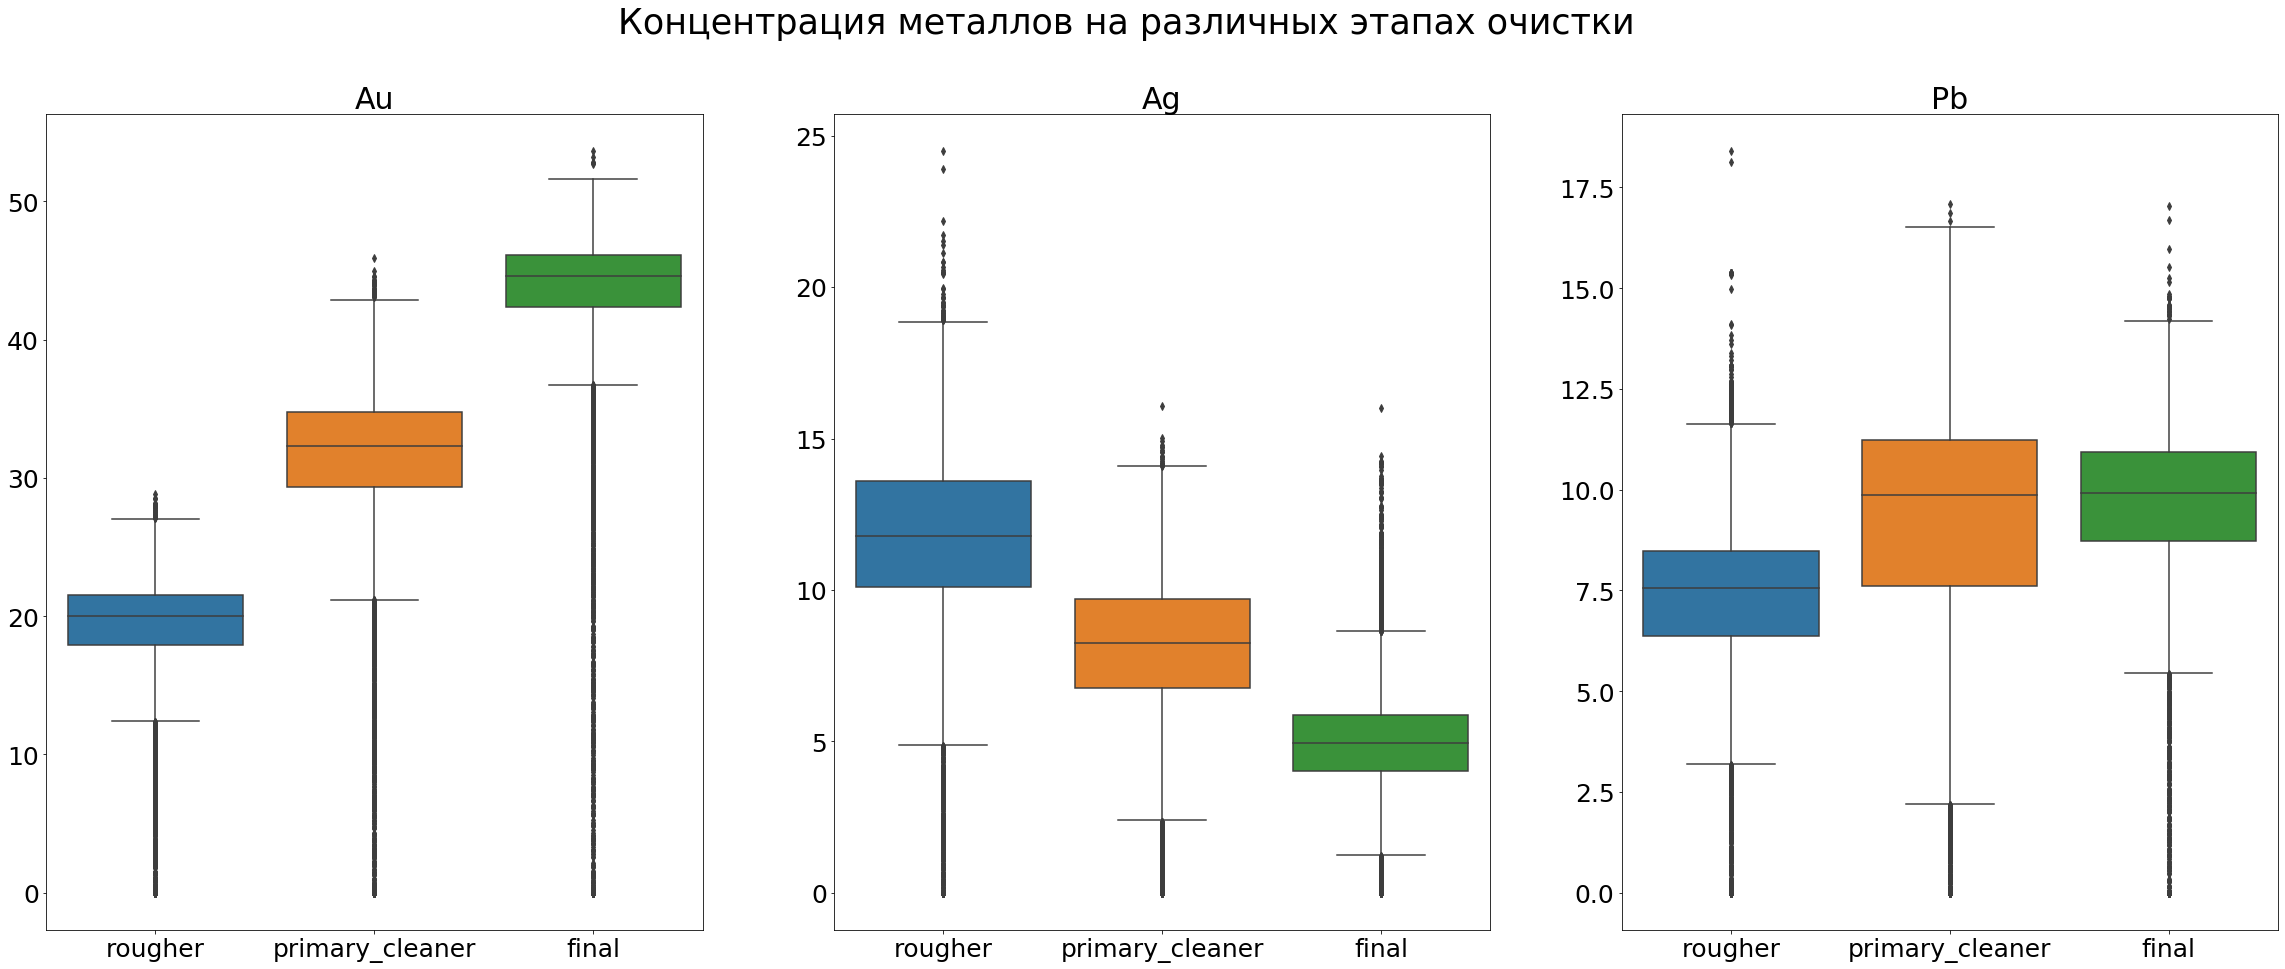

In [12]:
# Построим диаграммы размаха
element = ['au', 'ag', 'pb']
titles = ['Au', 'Ag', 'Pb']
element_col = ([['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 
            'final.output.concentrate_au'],['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag',
            'final.output.concentrate_ag'], ['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb']])

fig, axes = plt.subplots(1, 3, figsize=(40,15))
fig.suptitle('Концентрация металлов на различных этапах очистки', fontsize = 35)

for i in range(0,len(element)):
    sns.boxplot(data = data[element_col[i]], ax = axes[i])
    axes[i].set_title(titles[i], fontsize = 30)
    plt.setp(axes, xticks=range(3), xticklabels=['rougher', 'primary_cleaner', 'final'])
    plt.setp(axes[i].get_xticklabels(), fontsize = 25)
    plt.setp(axes[i].get_yticklabels(), fontsize = 25)

### 2.1. Выводы.

Концентрация металлов на различных этапах очистки в динамике ощутимо отличается:

- `Au`. На этапе флотации медиана составляет 20, на этапе черновой очистки растет до 33, после финального этапа вновь растет до 44. Наблюдается очевидный тренд, так как цель всего процесса как раз и заключается в очистке золотосодержащей руды от примесей   
- `Ag`. На этапе флотации медиана составляет 12, на этапе черновой очистки падает до 8, после финального этапа вновь падает до 5. Серебро в данном процессе - это примесь, поэтому тренд от начального этапа к финальному- падающий   
- `Pb`. На этапе флотации медиана составляет 7.5, на этапе черновой очистки растет до 10, после финального этапа остается на том же уровне 10. 

### 2.2. Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

Рассмотрим распределения размеров гранул на двух этапах - флотации и первичной очистки

#### Флотация ( `rougher.input.feed_size` )

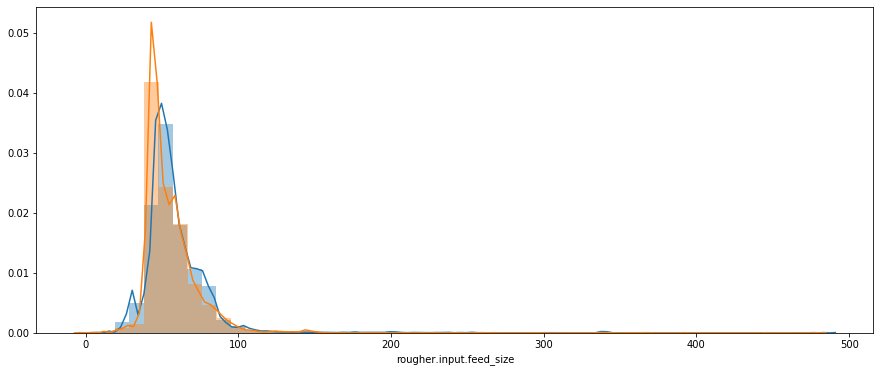

In [13]:
plt.figure(figsize=(15, 6))
sns.distplot(data_train['rougher.input.feed_size'])  # гистограмма и кривая распределения data_train
sns.distplot(data_test['rougher.input.feed_size'])  # гистограмма и кривая распределения data_test
show()

Дополнительно рассмотрим распределения на примере "ящиков с усами"

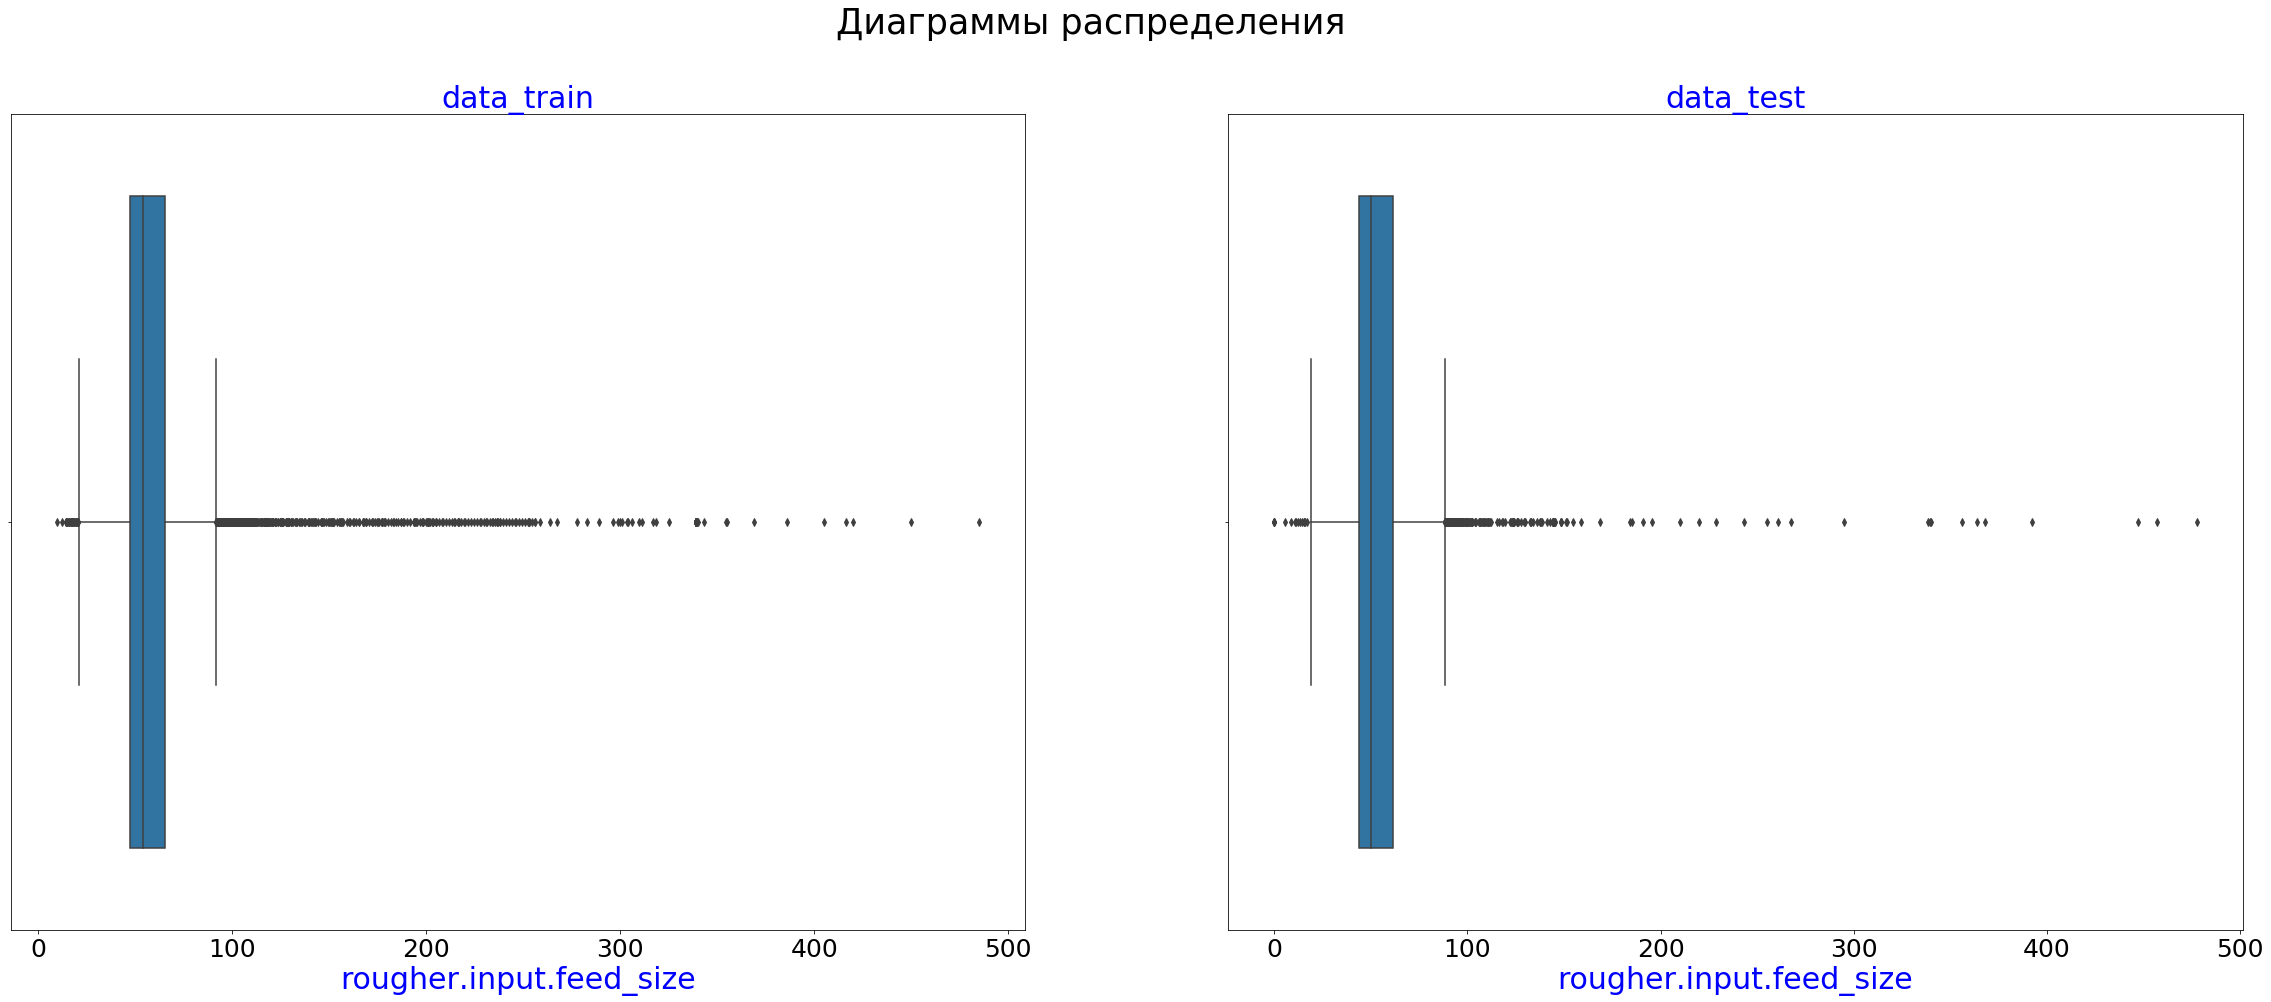

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(40,15))
fig.suptitle('Диаграммы распределения', fontsize = 35)

# Для обучающей выборки
sns.boxplot(data_train['rougher.input.feed_size'], ax = axes[0])
axes[0].set_title('data_train', fontsize = 30, color = 'blue')
axes[0].set_xlabel('rougher.input.feed_size', fontsize=30, color = 'blue')
plt.setp(axes[0].get_xticklabels(), fontsize = 25)
plt.setp(axes[0].get_yticklabels(), fontsize = 25)

# Для тестовой выборки
sns.boxplot(data_test['rougher.input.feed_size'], ax = axes[1])
axes[1].set_title('data_test', fontsize = 30, color = 'blue')
axes[1].set_xlabel('rougher.input.feed_size', fontsize=30, color = 'blue')
plt.setp(axes[1].get_xticklabels(), fontsize = 25)
plt.setp(axes[1].get_yticklabels(), fontsize = 25)

plt.show()

Распределения очень похожи, но наблюдаются значительные аномальные выбросы. Избавимся от них.

In [15]:
# Удаляем аномальные выбросы
data_train = data_train.loc[((30 < data_train['rougher.input.feed_size'])
                             & (data_train['rougher.input.feed_size'] < 100))]
data_test = data_test.loc[((30 < data_test['rougher.input.feed_size'])
                           & (data_test['rougher.input.feed_size'] < 100))]

Оценим основные статистические показатели  признака `rougher.input.feed_size` в обеих выборках после преобразований

In [16]:
data_train['rougher.input.feed_size'].describe()

count    15891.000000
mean        56.829862
std         12.938069
min         30.052520
25%         47.604162
50%         54.000411
75%         64.133851
max         99.944868
Name: rougher.input.feed_size, dtype: float64

In [17]:
data_test['rougher.input.feed_size'].describe()

count    5673.000000
mean       54.201047
std        12.932875
min        30.252351
25%        43.911874
50%        49.712395
75%        61.019873
max        99.938789
Name: rougher.input.feed_size, dtype: float64

#### Первичная очистка ( `primary_cleaner.input.feed_size` )

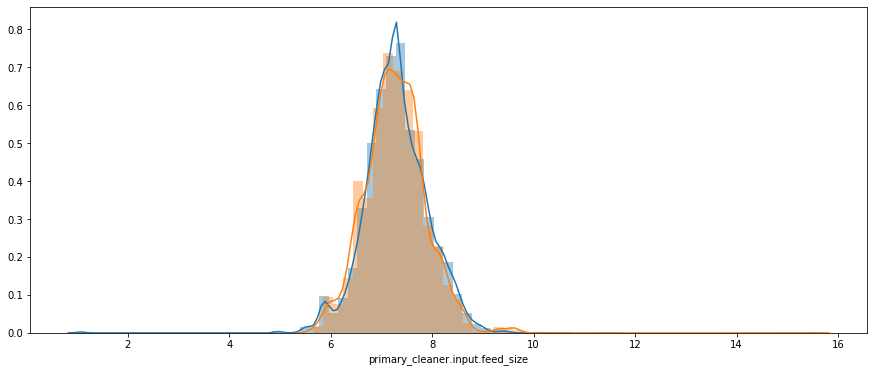

In [18]:
plt.figure(figsize=(15, 6))
sns.distplot(data_train['primary_cleaner.input.feed_size'])  # гистограмма и кривая распределения data_train
sns.distplot(data_test['primary_cleaner.input.feed_size'])  # гистограмма и кривая распределения data_test
show()

Строим "ящики с усами"

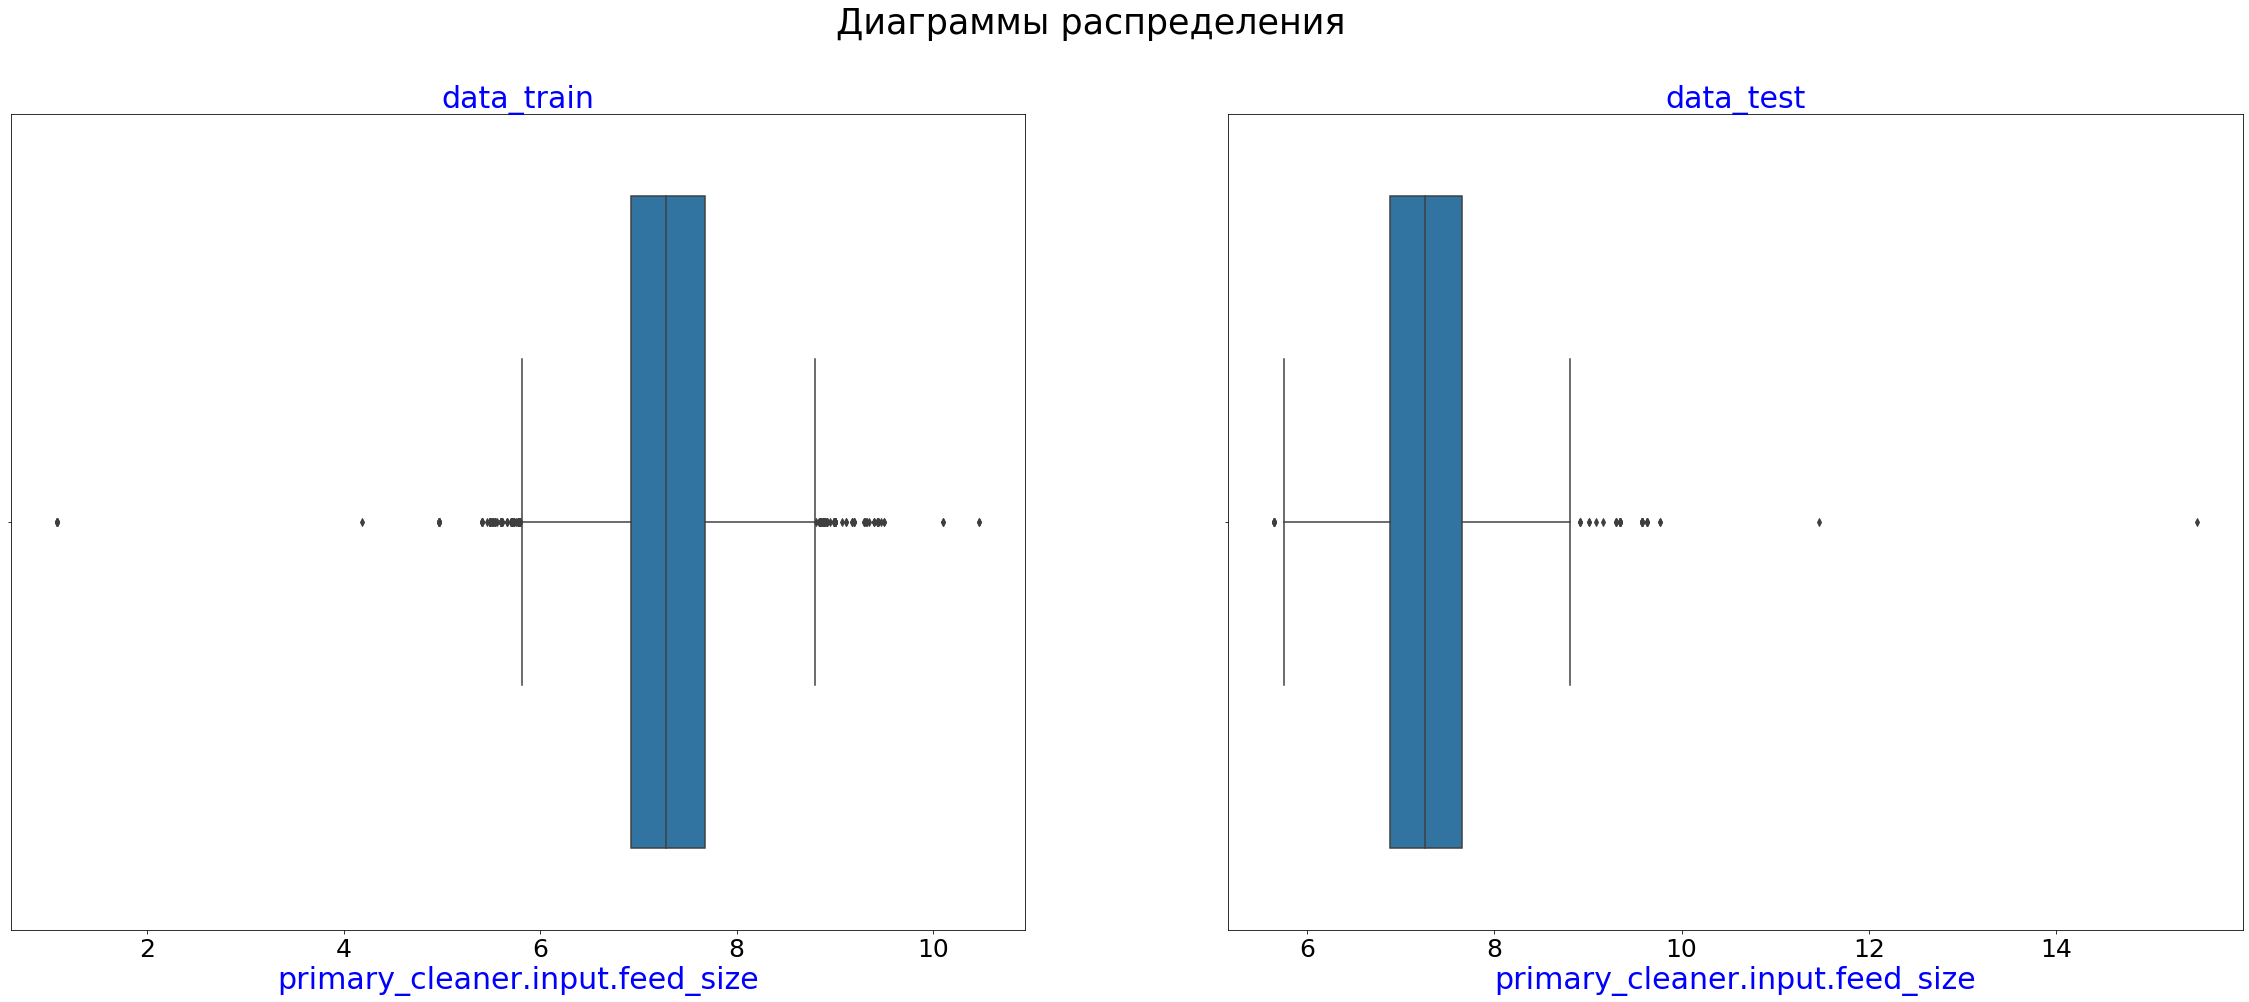

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(40,15))
fig.suptitle('Диаграммы распределения', fontsize = 35)

# Для обучающей выборки
sns.boxplot(data_train['primary_cleaner.input.feed_size'], ax = axes[0])
axes[0].set_title('data_train', fontsize = 30, color = 'blue')
axes[0].set_xlabel('primary_cleaner.input.feed_size', fontsize=30, color = 'blue')
plt.setp(axes[0].get_xticklabels(), fontsize = 25)
plt.setp(axes[0].get_yticklabels(), fontsize = 25)

# Для тестовой выборки
sns.boxplot(data_test['primary_cleaner.input.feed_size'], ax = axes[1])
axes[1].set_title('data_test', fontsize = 30, color = 'blue')
axes[1].set_xlabel('primary_cleaner.input.feed_size', fontsize=30, color = 'blue')
plt.setp(axes[1].get_xticklabels(), fontsize = 25)
plt.setp(axes[1].get_yticklabels(), fontsize = 25)

plt.show()

Распределения также очень схожи, но опять же много аномалий. Избавимся от них.

In [20]:
# Удаляем аномальные выбросы
data_train = data_train.loc[((5.8 < data_train['primary_cleaner.input.feed_size'])
                             & (data_train['primary_cleaner.input.feed_size'] < 8.8))]
data_test = data_test.loc[((5.8 < data_test['primary_cleaner.input.feed_size'])
                           & (data_test['primary_cleaner.input.feed_size'] < 8.8))]

Оценим статистику признака `primary_cleaner.input.feed_size`

In [21]:
data_train['primary_cleaner.input.feed_size'].describe()

count    15640.000000
mean         7.295080
std          0.567343
min          5.800000
25%          6.940000
50%          7.280000
75%          7.670000
max          8.800000
Name: primary_cleaner.input.feed_size, dtype: float64

In [22]:
data_test['primary_cleaner.input.feed_size'].describe()

count    5610.000000
mean        7.258973
std         0.557926
min         5.800000
25%         6.890000
50%         7.260000
75%         7.640000
max         8.789999
Name: primary_cleaner.input.feed_size, dtype: float64

### 2.2. Выводы.

Распределение размеров гранул сырья в обучающей и тестовой выборках отличаются друг от друга очень незначительно, однако при анализе диаграмм размаха были замечены и устранены аномальные выбросы по исследуемым признакам `primary_cleaner.input.feed_size` и `rougher.input.feed_size`

### 2.3. Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [23]:
# Создаем функцию для подсчета суммарной концентрации веществ на разных стадиях
sample_name = ['data', 'data_train']

def sum_func(df):
    df['rouger_sum'] = (df['rougher.output.concentrate_au'] +
                       df['rougher.output.concentrate_ag'] +
                       df['rougher.output.concentrate_pb'] +
                       df['rougher.output.concentrate_sol'])

    df['primary_sum'] = (df['primary_cleaner.output.concentrate_au'] + 
                        df['primary_cleaner.output.concentrate_ag'] +
                        df['primary_cleaner.output.concentrate_pb'] +
                        df['primary_cleaner.output.concentrate_sol'])

    df['final_sum'] = (df['final.output.concentrate_au'] +
                      df['final.output.concentrate_ag'] +
                      df['final.output.concentrate_pb'] +
                      df['final.output.concentrate_sol'])

Проанализируем датасет `data`

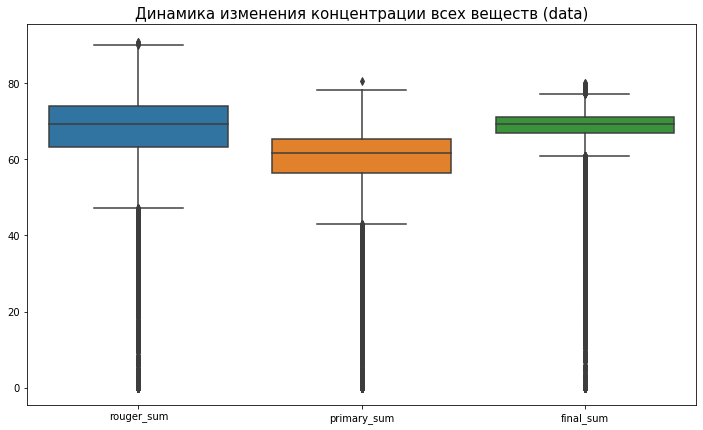

In [24]:
sum_func(data)

sns.mpl.rc("figure", figsize=(12,7))
sns.boxplot(data=data[['rouger_sum', 'primary_sum', 'final_sum']]).set_title('Динамика изменения концентрации всех веществ (data)', fontsize = 15)
plt.show()

Более подробно изучим аномалии на этапе флотации (на следующих этапах этот процесс пропустим)


 Датасет data: mu = 61.53  и sigma = 23.39 



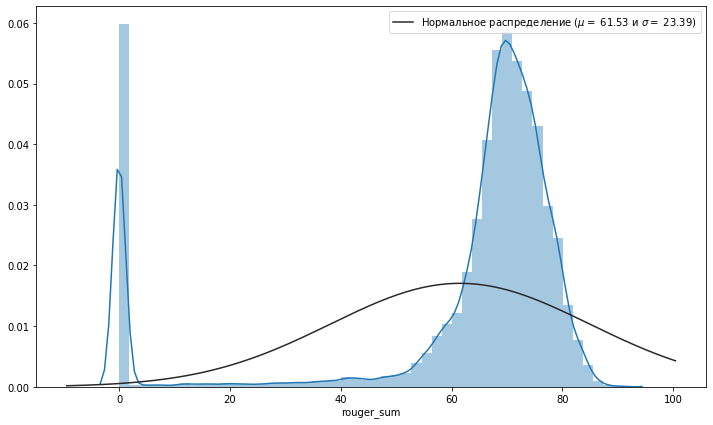

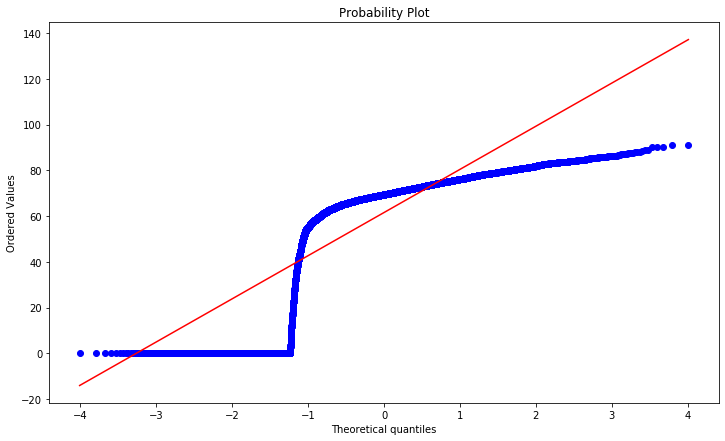

In [25]:
# Строим гистограмму
sns.distplot(data['rouger_sum'], fit=norm);
(mu, sigma) = norm.fit(data['rouger_sum'])
print('\n Датасет data: mu = {:.2f}  и sigma = {:.2f} \n'.format(mu, sigma))
plt.legend(['Нормальное распределение ($\mu=$ {:.2f} и $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')
#Строим график нормального распределения, сравнивающий распределение выборочных данных  и нормальное распределение
fig =  plt.figure()
res = stats.probplot(data['rouger_sum'], plot=plt)
plt.show()

In [26]:
#Удаляем нижние аномальные выбросы в data
data = data.loc[(data['rouger_sum'] > 45)&(data['primary_sum'] > 40)&(data['final_sum'] > 60)]


 Датасет data: mu = 70.35  и sigma = 6.47 



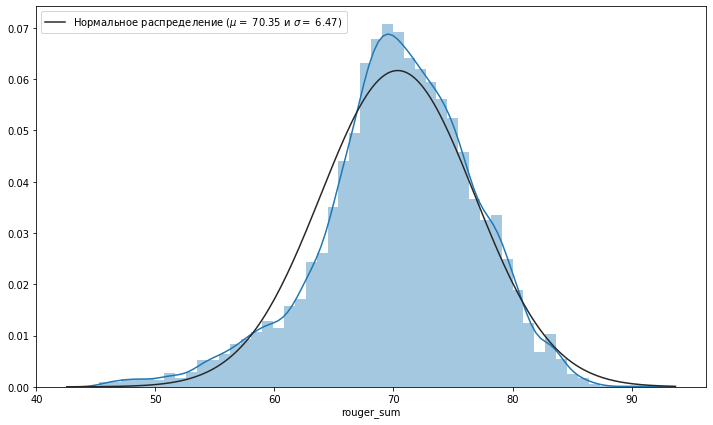

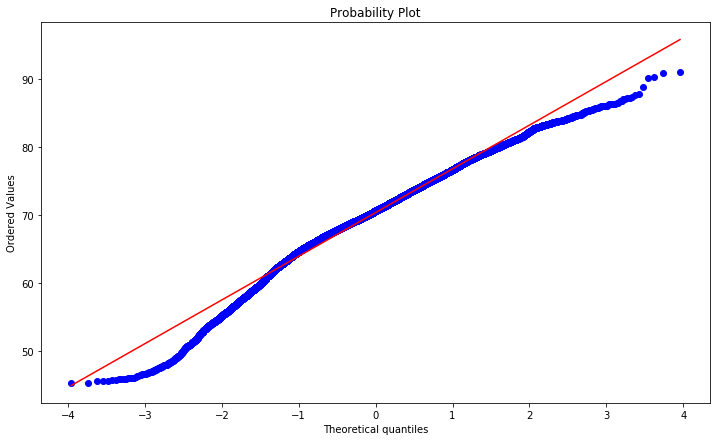

In [27]:
# Строим гистограмму
sns.distplot(data['rouger_sum'], fit=norm);
(mu, sigma) = norm.fit(data['rouger_sum'])
print('\n Датасет data: mu = {:.2f}  и sigma = {:.2f} \n'.format(mu, sigma))
plt.legend(['Нормальное распределение ($\mu=$ {:.2f} и $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')
#Строим график нормального распределения, сравнивающий распределение выборочных данных  и нормальное распределение
fig =  plt.figure()
res = stats.probplot(data['rouger_sum'], plot=plt)
plt.show()

Рассчитаем суммарные концентрации в `data_train` и удалим аномальные выбросы

In [28]:
sum_func(data_train)
data_train = data_train.loc[(data_train['rouger_sum'] > 45) &
                (data_train['primary_sum'] > 40) &
                (data_train['final_sum'] > 60)]


 Датасет data_train: mu = 69.49  и sigma = 6.83 



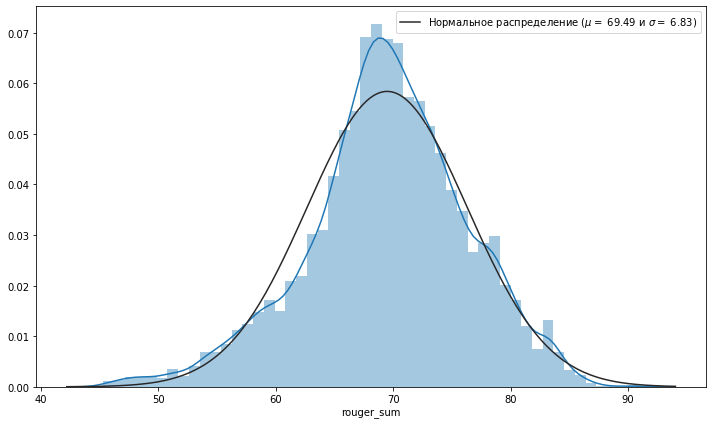

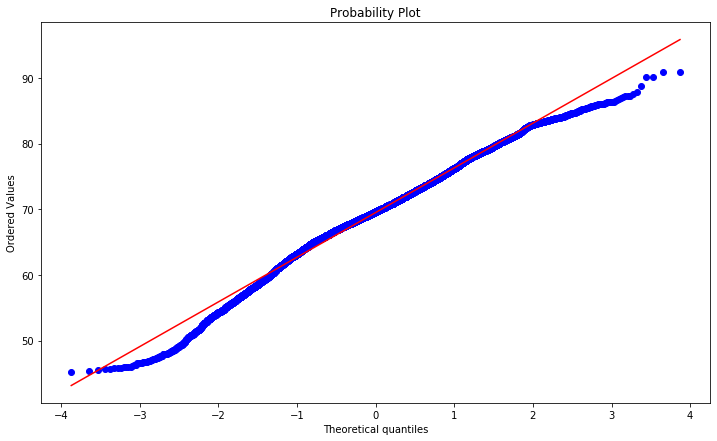

In [29]:
# Строим гистограмму
sns.distplot(data_train['rouger_sum'], fit=norm);
(mu, sigma) = norm.fit(data_train['rouger_sum'])
print('\n Датасет data_train: mu = {:.2f}  и sigma = {:.2f} \n'.format(mu, sigma))
plt.legend(['Нормальное распределение ($\mu=$ {:.2f} и $\sigma=$ {:.2f})'.format(mu,sigma)], loc='best')
#Строим график нормального распределения, сравнивающий распределение выборочных данных  и нормальное распределение
fig =  plt.figure()
res = stats.probplot(data_train['rouger_sum'], plot=plt)
plt.show()

### 2.3. Выводы.

После исследования суммарных концентраций всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах, были обнаружены аномальные выбросы в зоне "нижнего уса" на всех трех стадиях. Аномальные выбросы из обеих выборок были удалены, для улучшения качества модели с обучением.

# 3. Модель

### 3.1. Напишите функцию для вычисления итоговой sMAPE.

In [30]:
def smape_final(R_predict, R_valid, F_predict, F_valid):
    rougher = 1/len(R_valid) * np.sum(np.abs(R_predict - R_valid) / ((np.abs(R_predict) + np.abs(R_valid))/2))*100
    final = 1/len(F_valid) * np.sum(np.abs(F_predict - F_valid) / ((np.abs(F_predict) + np.abs(F_valid))/2))*100
    smape_final = 0.25*rougher  +  0.75*final
    return smape_final

### 3.2. Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы.

#### Финальная подготовка обучающей выборки

Создадим датасет `data_train_final` (на котором будем обучать модели) в котором оставим только признаки, которые есть в датасете `data_test` и целевой признак

In [31]:
# Создаем датасет df_train_final для обучения
data_train_final = data_train.drop(data_train[abcent_columns], axis=1)

# Удаляем столбцы с расчетами суммарных концентраций
data_train_final = data_train_final.drop(data_train_final[['primary_sum','rouger_sum','final_sum']], axis=1) 

# Создаем датасет df_train_rougher для обучения
data_train_rougher = data_train_final

In [32]:
data_train_final.shape, data_train_final.shape, data_train_rougher.shape

((12790, 54), (12790, 54), (12790, 54))

#### Готовим данные

In [33]:
features_r = data_train_rougher.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_f = data_train_final.drop(['final.output.recovery'], axis=1)

Сохраним названия признаков для дальнейшего использования в тестовой модели

In [34]:
r_columns = features_r.columns 
f_columns = features_f.columns

target_r = data_train['rougher.output.recovery']
target_f = data_train['final.output.recovery']

In [35]:
target_r_test = data['rougher.output.recovery'].loc[data_test.index]
target_r_test = target_r_test.dropna()
target_f_test = data['final.output.recovery'].loc[data_test.index]
target_f_test = target_f_test.dropna()

In [36]:
features_r_test = data[r_columns].loc[target_r_test.index]
features_f_test = data[f_columns].loc[target_f_test.index]

#### Алгоритм DecisionTreeRegressor. Обучение.

In [37]:
i=0
result = pd.DataFrame(columns=['max_depth', 'score_DTR_r', 'score_DTR_f', 'smape_total'])

for max_depth in range(2,101,10):
    model_DTR = DecisionTreeRegressor(random_state=12345, max_depth = max_depth)
    
    model_DTR.fit(features_r, target_r)
    predicted_ror = model_DTR.predict(features_r_test)
    score_r = cross_val_score(model_DTR, features_r_test, target_r_test, cv=5)
    
    model_DTR.fit(features_f, target_f)
    predicted_for = model_DTR.predict(features_f_test)
    score_f = cross_val_score(model_DTR, features_f_test, target_f_test, cv=5)
    
    smape_total = smape_final(predicted_ror, target_r_test, predicted_for, target_f_test)
    result.loc[i] = [max_depth, score_r.sum()/5, score_f.sum()/5, smape_total]
    
    i+=1
result

,max_depth,score_DTR_r,score_DTR_f,smape_total
0,2.0,-0.182634,0.174374,5.851079
1,12.0,-0.970721,-1.239511,9.056968
2,22.0,-1.204954,-1.576818,10.212091
3,32.0,-1.359921,-1.262428,16.473626
4,42.0,-1.411956,-1.365307,15.911973
5,52.0,-1.411956,-1.335101,15.911973
6,62.0,-1.411956,-1.335101,15.911973
7,72.0,-1.411956,-1.335101,15.911973
8,82.0,-1.411956,-1.335101,15.911973
9,92.0,-1.411956,-1.335101,15.911973


#### Алгоритм RandomForestRegressor. Обучение.

In [38]:
i=0
result = pd.DataFrame(columns=['estimators', 'score_RFR_r', 'score_RFR_f', 'smape_total'])

for estimators in range(100, 201, 10):
    model_RFR = RandomForestRegressor(random_state=12345,n_estimators= estimators)
    
    model_RFR.fit(features_r, target_r)
    predicted_ror = model_RFR.predict(features_r_test)
    score_r = cross_val_score(model_RFR, features_r_test, target_r_test, cv=5)
    
    model_RFR.fit(features_f, target_f)
    predicted_for = model_RFR.predict(features_f_test)
    score_f = cross_val_score(model_RFR, features_f_test, target_f_test, cv=5)
    
    smape_total = smape_final(predicted_ror, target_r_test, predicted_for, target_f_test)
    result.loc[i] = [estimators, score_r.sum()/5, score_f.sum()/5, smape_total]
    
    i+=1
result

,estimators,score_RFR_r,score_RFR_f,smape_total
0,100.0,-0.144070,0.072299,5.848445
1,110.0,-0.131434,0.072405,5.833003
2,120.0,-0.129992,0.065482,5.825031
3,130.0,-0.132397,0.070957,5.822813
4,140.0,-0.134517,0.074058,5.826144
5,150.0,-0.137990,0.077567,5.814535
6,160.0,-0.139337,0.079043,5.832872
7,170.0,-0.134903,0.085155,5.833463
8,180.0,-0.137134,0.088425,5.831159
9,190.0,-0.138049,0.083275,5.830958


Наилучшее значение sMAPE = 5.814535 % достигается при n_estimators = 150

P.S. Вероятно значение sMAPE можно еще более уменьшить за счет увеличения количества деревьев, но в таком случае это серъезно увеличивает время обучения, а результаты изменяются незначительно. 

#### Алгоритм LinearRegression. Обучение.

In [46]:
model_lr_rec = LinearRegression()
model_lr_rec.fit(features_r, target_r)
predicted_ror = model_lr_rec.predict(features_r_test)
final_score_rec = statistics.mean(cross_val_score(model_lr_rec, features_r_test, target_r_test, cv=5))  

model_lr_rec = LinearRegression()
model_lr_rec.fit(features_f, target_f)
predicted_for = model_lr_rec.predict(features_f_test)
final_score_fin = statistics.mean(cross_val_score(model_lr_rec, features_f_test, target_f_test, cv=5)) 

print('\n Средняя оценка качества модели model_lr_rec: {:.2f}'.format(final_score_rec))
print('\n Средняя оценка качества модели model_lr_fin: {:.2f}'.format(final_score_fin))
print('\n Итоговое sMAPE: {:.10f}'.format(smape_final(predicted_ror, target_r_test, predicted_for, target_f_test)), "%")


 Средняя оценка качества модели model_lr_rec: -0.57

 Средняя оценка качества модели model_lr_fin: -0.02

 Итоговое sMAPE: 6.1532234780 %


Наилучшие результаты показывает алгоритм RandomForestRegressor (при n_estimators = 150). Значение sMAPE = `5.814535 %`). Но прежде чем тестировать его на тестовой выборке - сравним наш лучший результат с результатом работы обычной(примитивной) модели, для подтверждения большей эффективности.

#### R2 и sMAPE "примитивной" модели

Обозначим предикативные значения равными среднему арифметическому целевых признаков

In [47]:
# Определяем в качестве предикативных значений среднее по целевому признаку rougher.output.recovery
predicted_ror = pd.Series(target_r.mean(), index=target_r.index)
mse_ror = mean_squared_error(target_r, predicted_ror)
r2_ror = r2_score(target_r, predicted_ror)
print('\n Средняя R2 примитивной модели rougher.output.recovery: {:.5f}'.format(r2_ror))

# Определяем в качестве предикативных значений среднее по целевому признаку final.output.recovery
predicted_for = pd.Series(target_f.mean(), index=target_f.index)
r2_for = r2_score(target_f, predicted_for)
print('\n Средняя R2 примитивной модели final.output.recovery: {:.5f}'.format(r2_for))

print('\n Итоговое sMAPE примитивной модели: {:.2f}'.format(smape_final(predicted_ror, target_r, predicted_for, target_f)), "%")


 Средняя R2 примитивной модели rougher.output.recovery: 0.00000

 Средняя R2 примитивной модели final.output.recovery: 0.00000

 Итоговое sMAPE примитивной модели: 8.99 %


Результаты "примитивной" модели определенно хуже. Mожем приступать к тестированию нашего алгоритма RandomForestRegressor.

#### Подготовка тестовой выборки

In [54]:
#Из исходного датасета, на основании индексов data_test, создаем тестовую выборку
idx = data_test.index
data_test[['rougher.output.recovery', 'final.output.recovery']]= data[['rougher.output.recovery', 'final.output.recovery']].loc[idx]
data_test= data_test.dropna()

#### Обучение тестовой выборки на лучшей модели 

In [55]:
# Разбиваем тестовую выборку на тестовую и валидационную и объявляем переменные признаков
data_test_trainpart, data_test_validpart = train_test_split(
        data_test, test_size=0.25, random_state = 12345)

features_r_trainpart = data_test_trainpart[r_columns]
features_f_trainpart = data_test_trainpart[f_columns]
target_rec_trainpart = data_test_trainpart['rougher.output.recovery']
target_fin_trainpart = data_test_trainpart['final.output.recovery']


features_r_validpart = data_test_validpart[r_columns]
features_f_validpart = data_test_validpart[f_columns]
target_rec_validpart = data_test_validpart['rougher.output.recovery']
target_fin_validpart = data_test_validpart['final.output.recovery']

In [56]:
model_RFR = RandomForestRegressor(random_state=12345,n_estimators = 150)
model_RFR.fit(features_r_trainpart, target_rec_trainpart)
predicted_ror = model_RFR.predict(features_r_validpart)
final_score_rec = statistics.mean(cross_val_score(model_RFR, features_r_validpart, target_rec_validpart, cv=5))  

model_RFR.fit(features_f_trainpart, target_fin_trainpart)
predicted_for = model_RFR.predict(features_f_validpart)
final_score_fin = statistics.mean(cross_val_score(model_RFR, features_f_validpart, target_fin_validpart, cv=5)) 

print('\n Средняя оценка качества модели model_rfr_rec: {:.2f}'.format(final_score_rec))
print('\n Средняя оценка качества модели model_rfr_fin: {:.2f}'.format(final_score_fin))
print('\n Итоговое sMAPE: {:.10f}'.format(smape_final(predicted_ror, target_rec_validpart, predicted_for, target_fin_validpart)), "%")


 Средняя оценка качества модели model_rfr_rec: 0.56

 Средняя оценка качества модели model_rfr_fin: 0.43

 Итоговое sMAPE: 3.9233862170 %


# Общий вывод

### Цели проекта

На основании исторических данных с параметрами добычи и очистки золотосодержащей руды:

- подготовить данные
- провести исследовательский анализ данных
- построить и обучить модель

Модель призвана оптимизировать процесс производства, чтобы не запускать предприятие с убыточными характеристиками.

### Исходные данные

- Общий датасет `gold_recovery_full` - 22 716 атрибутов, 86 признаков, из них 2 целевых
- Обучающий датасет `gold_recovery_train`- 16 860 атрибутов, 86 признаков, из них 2 целевых
- Тестовый датасет `gold_recovery_test` - 5 876 атрибутов, 52 признака, целевые признаки отсутствуют  

В качестве индекса, для всех датасетов, была установлена дата/время записи значений атрибута.

### Результаты исследования

- в ходе анализа первичных данных подтвержден факт того, что эффективность обогащения `rougher.output.recovery` рассчитана верно
- расчитано `МАЕ`, на обучающей выборке, для признака `rougher.output.recovery`, между расчетами и значением признака ( МАЕ = `9.55 * 10 (-15)` )
- по условиям, для тестовой выборки некоторые параметры недоступны, така как замеряются и/или рассчитываются значительно позже. В связи с этим в тестовой выборке отсутствуют признаки, которые есть в обучающей. Они относятся к типам `output` (параметры продукта) и `state` (расчётные характеристики). В тестовом наборе данных отсутствуют целевые признаки: `rougher.output.recovery` и `final.output.recovery`.
- в связи с вышеуказанным, в ходе машинного обучения, в качестве признаков для обучения, брались 52 признака из тестовой модели
- проведено сравнение распределения размеров гранул сырья на обучающей и тестовой выборках. Распределения отличаются друг от друга незначительно. Были устранены аномальные выбросы признака в обеих выборках.
- исследована суммарная концентрация всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Были обнаружены аномальные значения в суммарном распределении. Аномалии были удалены из обеих выборок
- подготовлена функция для вычисления итоговой `sMAPE`
- осуществлено машинное обучение, на обучающих выборках, тремя алгоритмами регрессии:
  - DecisionTreeRegressor
  - RandomForestRegressor
  - LinearRegression
  
Лучшее значение sMAPE = `5.814535 %`, на обучающей выборке, было показано алгоритмом  `RandomForestRegressor(n_estimators= 150)`

- перед финальным тестированием успешного алгоритма было проведено сравнение его эффективности с эффективностью примитивной "модели", где в качестве предикативных значений было использовано среднее арифметическое целевых признаков. Полученнoe на алгоритме `RandomForestRegressor (n_estimators= 150)` значение sMAPE оказалось лучше, чем у примитивной "модели":

`RandomForestRegressor (n_estimators= 150)`:
    - R2_1 = -0.14
    - R2_2 = 0.08
    - sMAPE =  5.814535 %

`примитивная "модель"`:
    - R2_1 = 0.00
    - R2_2 = 0.00
    - sMAPE = 8.99 %


- проведено моделирование на тестовой выборке. Обучение на тестовой выборке (алгоритм `RandomForestRegressor (n_estimators= 150)`) показало итоговое sMAPE = `3.9233862170 %`, что достаточно близко к показателям обучения на обучающей выборке (sMAPE = `5.814535 %`). Это подтверждает стабильность предсказаний выбранной нами модели.

===================================================================================================================
#### Благодарю за внимание.